# Multi-armed Bandits

In this notebook we'll explore the MAB framework and different methods to address the exploration-exploitation trade-off:
- Understand the MAB problem and how to formulate it as a reinforcement learning problem
- Implement and compare exploration strategies: random, (mostly) greedy, epsilon-greedy, softmax, and UCB
- Observe the trade-off between exploration and exploitation by comparing reward and regret of all strategies

The only libraries you'll need are NumPy and Matplotlib.

In [184]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Create the multi-armed Bandit 
- Complete the following MAB class (marked as TODO)


In [185]:
class MultiArmedBandit:
    def __init__(self, k=10, mean_range=(0, 1), std_range=(0.1, 0.4), seed=None):
        """ A k-armed bandit environment
        Args:
            k (int): number of arms
            seed (int or None): random seed for reproducibility
            mean_range (tuple): range of the mean reward for each arm
            std_range (float): standard deviation of the reward for each arm
        """
        print(seed)
        self.rng = np.random.RandomState(seed)  # random number generator
        self.k = k  # number of arms
        # Sample the mean reward for each arm from a uniform distribution
        # Uses the random number generator
        self.means = self.rng.uniform(mean_range[0], mean_range[1], k)  
        self.stds = self.rng.uniform(std_range[0], std_range[1], k)

    def step(self, action):
        """Take an action and return the reward for that action"""
        if action < 0 or action >= self.k:
            raise ValueError("Invalid action")
        # Sample reward from a normal distribution with mean and std of the selected arm
        return self.rng.normal(self.means[action], self.stds[action])
    def highest_reward(self):
        max = 0
        for i in range(self.k):
            if(self.step(i))>max:
                max = self.step(i)
        """Return the mean of the best arm"""
        return max

    def best_arm(self):
        maxIndex = 0
        max = 0
        for i in range(self.k):
            if(self.step(i))>max:
                maxIndex = i
                max = self.step(i)
        """Return the mean of the best arm"""
        return maxIndex


### 2. Understand the environment
- Create a bandit environment with 8 arms
- Print the optimal arm and the highest reward
- Plot the mean and standard deviation of all arms

1
0.6198385840566557
1


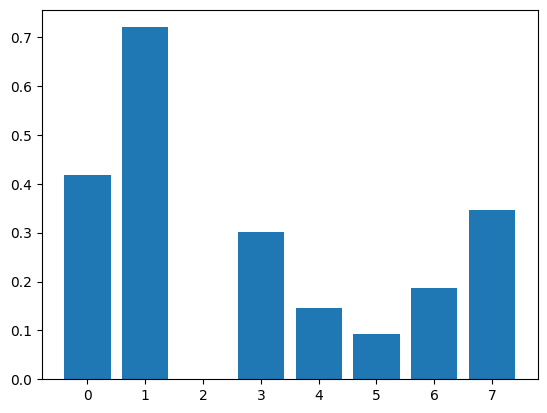

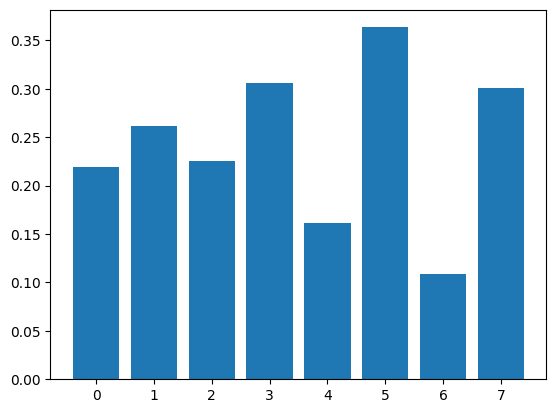

In [186]:
b = MultiArmedBandit(8,seed=1)


f = plt.figure()
plt.bar(range(8),b.means)

f2 = plt.figure()
plt.bar(range(8),b.stds)

print(b.highest_reward())
print(b.best_arm())


### 3. Implement different exploration strategies

To compare the different strategies set up a function for each of the below mentioned strategies. Each function:
- inputs an instance of the bandit, the number of steps to run (i.e. arm pulls) as well as strategy-specific parameters, e.g. epsilon
- runs for 1000 steps (default) and with each step chooses an action (depending on the strategy) and updates *N*, *Q* and the *cumulative rewards* for each step 
- updates the estimated reward Q after each pull using incremental averaging: $Q_{t+1}(a)= Q_{t}(a) + \frac{1}{N(a)} (R-Q_t(a))$
- returns: 
  - the *cumulated rewards* for all steps, 
  - *N*: how often each arm was called

*Mostly Greedy*
- Choose each arm once
- For the remaining runs, choose greedily, i.e. the arm with the highest action value Q 

*Epsilon-Greedy*   
- With a probability of 1-$\epsilon$ choose the arm with the highest estimated reward
- With a probability of $\epsilon$ choose a random arm
- Typical $\epsilon$-value: 0.1
  
*Softmax*
- Calculate a probability distribution over the action values by converting the estimated rewards into probabilities: $P(a) = \frac{e^{Q(a)/\tau}}{\sum_i e^{Q(i)/\tau}}$
- In each run, sample an arm according to this probability distribution
- Typical $\tau$-value: 0.1

*Upper Confidence Bound*
- In each run, select the arm that maximises $Q(a) + c \sqrt{\frac{\text{ln}\: t}{N(a)}}$
- Typical $c$-value: 2.0


In [187]:
import random, math
def run_mostly_greedy(mab, steps=1000, random_threshold=100,seed=None):
    k = mab.k  # number of arms/levers
    Q = np.zeros(k)
    N = np.zeros(k, dtype=int)
    cumulative_rewards = np.zeros(steps)
    total_reward = 0
    rng = np.random.RandomState(seed)
    for t in range(steps):
        # add some randomness at the beginning
        if t < random_threshold:
            action = rng.randint(0, k)  # returns each integer (0 .. k-1) with equal probability
        else:
            action = np.argmax(Q)  # take the action with the highest Q-value

        reward = mab.step(action)  # returns a reward based on the arm's prob. distr.
        total_reward += reward     # add the current reward to the sum of previous rewards
        cumulative_rewards[t] = total_reward  # for each step, store the total reward up until that step

        N[action] += 1  # count how often the arm was chosen
        Q[action] += (reward - Q[action]) / N[action]  # calculate the action value for each arm

    return cumulative_rewards, N

def run_epsilon_greedy(mab, steps=1000, epsilon=0.1,seed=None):
    k = mab.k  # number of arms/levers
    Q = np.zeros(k)
    N = np.zeros(k, dtype=int)
    cumulative_rewards = np.zeros(steps)
    total_reward = 0
    rng = random.Random(seed)
    rng2 = np.random.RandomState(seed)
    for t in range(steps):
        # add some randomness at the beginning
        x = rng.random()
        if x <= epsilon:
            action = rng2.randint(0, k)  # returns each integer (0 .. k-1) with equal probability
        else:
            action = np.argmax(Q)  # take the action with the highest Q-value

        reward = mab.step(action)  # returns a reward based on the arm's prob. distr.
        total_reward += reward     # add the current reward to the sum of previous rewards
        cumulative_rewards[t] = total_reward  # for each step, store the total reward up until that step

        N[action] += 1  # count how often the arm was chosen
        Q[action] += (reward - Q[action]) / N[action]  # calculate the action value for each arm

    return cumulative_rewards, N


def run_softmax(mab, steps=1000, tau=0.1,seed=None):
    k = mab.k  # number of arms/levers
    Q = np.zeros(k)
    N = np.zeros(k, dtype=int)
    cumulative_rewards = np.zeros(steps)
    total_reward = 0
    probabilities=np.zeros(k)
    for t in range(steps):
        div = np.exp(np.divide(Q,tau))
        for i in range(k):            
            probabilities[i]=np.divide(np.exp(Q[i]/tau),np.sum(div))
        rng = np.random.RandomState(seed)
        action = rng.choice(range(k),p=probabilities)
        reward = mab.step(action)  # returns a reward based on the arm's prob. distr.
        total_reward += reward     # add the current reward to the sum of previous rewards
        cumulative_rewards[t] = total_reward  # for each step, store the total reward up until that step

        N[action] += 1  # count how often the arm was chosen
        Q[action] += (reward - Q[action]) / N[action]  # calculate the action value for each arm

    return cumulative_rewards, N

def run_ucb(mab, steps=1000, c=2.0):
    k = mab.k  # number of arms/levers
    Q = np.zeros(k)
    N = np.ones(k, dtype=int) #dirty trick to avoid division by 0
    cumulative_rewards = np.zeros(steps)
    total_reward = 0
    probabilities=np.zeros(k)
    for t in range(1,steps):#avoid ln0
        for i in range(k): 
            probabilities[i]=Q[i]+c*np.sqrt(np.log(t)/N[i])
        action = np.argmax(probabilities)
        reward = mab.step(action)  # returns a reward based on the arm's prob. distr.
        total_reward += reward     # add the current reward to the sum of previous rewards
        cumulative_rewards[t] = total_reward  # for each step, store the total reward up until that step

        N[action] += 1  # count how often the arm was chosen
        Q[action] += (reward - Q[action]) / N[action]  # calculate the action value for each arm

    return cumulative_rewards, N
print(run_mostly_greedy(b,1000,1000))
print(run_epsilon_greedy(b,1000,0.1))
print(run_softmax(b,1000,0.1))
print(run_ucb(b,1000,0.1))



(array([2.65527383e-01, 8.82043292e-01, 9.93940231e-01, 1.00433430e+00,
       1.10155698e+00, 1.09881221e+00, 1.52679802e+00, 1.94295075e+00,
       2.30882857e+00, 2.57530266e+00, 2.86309398e+00, 2.94135390e+00,
       3.01538041e+00, 3.38479176e+00, 3.53974475e+00, 3.64743321e+00,
       3.69064835e+00, 4.54629365e+00, 4.68230225e+00, 4.99895419e+00,
       5.19413827e+00, 5.82229834e+00, 5.49940557e+00, 5.46478071e+00,
       6.13044907e+00, 6.61203366e+00, 7.55187398e+00, 7.83889460e+00,
       8.27045716e+00, 8.55250406e+00, 8.38230679e+00, 9.06747309e+00,
       9.30924066e+00, 9.24205808e+00, 9.51194138e+00, 9.64650486e+00,
       1.03328447e+01, 1.07248013e+01, 1.20169707e+01, 1.17018144e+01,
       1.18025318e+01, 1.21090605e+01, 1.28712579e+01, 1.34801874e+01,
       1.36872389e+01, 1.30446383e+01, 1.31419926e+01, 1.36973259e+01,
       1.39084861e+01, 1.40806309e+01, 1.44489563e+01, 1.47340607e+01,
       1.50934000e+01, 1.55210304e+01, 1.56997791e+01, 1.58989180e+01,
     

### 4. Create a Function to Run Experiments

Set up a function called `experiment` that inputs:
- the number of bandit arms `k`
- the number of arm pulls each strategy performs, i.e. `steps` within the strategy function
- the number of `runs` to perform for the experiment, i.e. each strategy is called 200 times

Within the function:
- Set a seed, e.g. using a random number generator, to create repeatable experiments
- Set up variables for the `rewards` and `counts` of each strategy
- `Regret`: Create an empty list to store the true means of each bandit you create
- Run a loop for `runs` times
  - Every round, set up a bandit with a new seed. You can use the random number generator and `randint` to create a repeatable seed
  - Store the true means of the arms
  - Run the strategies and stor rewards and counts
- Now you have gathered the rewards and counts for 200 runs, where in each run each strategy has pulled its arm 1000 times
- Calculate the average cumulative reward over the 200 runs for every strategy
- Calculate the average regret: `Regret(t) = t * optimal reward - avg. cumulative reward`.    
  Tip: For `t`, you might use: `t_array = np.arange(1, steps + 1)  `, which is similar to range(1, steps+1) but as an array

Return:
- `Average cumulative rewards`, `Average regret` and `t_array` 


In [188]:

# Run experiments
def experiment(k, steps=1000, runs=200):
    baseSeed=100
    r1arr = np.zeros((runs,steps))
    n1arr = np.zeros((runs,k))
    r2arr = np.zeros((runs,steps))
    n2arr = np.zeros((runs,k))
    r3arr = np.zeros((runs,steps))
    n3arr = np.zeros((runs,k))
    r4arr = np.zeros((runs,steps))
    n4arr = np.zeros((runs,k))
    optimal_rewards = np.zeros(runs)
    t_arr=np.arange(1,steps+1)
    avg_regret_temp=np.zeros((runs,steps))
    rng = random.Random(baseSeed)

    for i in range(runs):
        bandit = MultiArmedBandit(k,seed=rng.randint(0,100000))
        optimal_rewards[i]=bandit.highest_reward()
        
        r1arr[i],n1arr[i] = run_mostly_greedy(bandit,steps,seed=rng.randint(0,100000))
        r2arr[i],n2arr[i] = run_epsilon_greedy(bandit,steps,seed=rng.randint(0,100000))
        r3arr[i],n3arr[i] = run_softmax(bandit,steps,seed=rng.randint(0,100000))
        r4arr[i],n4arr[i] = run_ucb(bandit,steps)
        
        avg_regret_temp[i]=np.multiply(t_arr,bandit.highest_reward())
        

    avg_rnd_per_timestep= np.average(r1arr,axis=0)
    avg_eps_per_timestep= np.average(r2arr,axis=0)
    avg_soft_per_timestep= np.average(r3arr,axis=0)
    avg_ucb_per_timestep= np.average(r4arr,axis=0)
    
    avg_rnd_regret = np.average(np.subtract(avg_regret_temp,r1arr),axis=0)
    avg_eps_regret = np.average(np.subtract(avg_regret_temp,r2arr),axis=0)
    avg_soft_regret = np.average(np.subtract(avg_regret_temp,r3arr),axis=0)
    avg_ucb_regret = np.average(np.subtract(avg_regret_temp,r4arr),axis=0)
        
    print(avg_rnd_regret)
    return {
        't': t_arr,
        'rnd_avg_reward': avg_rnd_per_timestep,
        'eps_avg_reward': avg_eps_per_timestep,
        'soft_avg_reward': avg_soft_per_timestep,
        'ucb_avg_reward': avg_ucb_per_timestep,
        'rnd_avg_regret': avg_rnd_regret,
        'eps_avg_regret': avg_eps_regret,
        'soft_avg_regret': avg_soft_regret,
        'ucb_avg_regret': avg_ucb_regret,
    }


### 5. Running the Experiment and Plotting 

After setting up the `experiment` function
- Run the function and plot the results for all strategies
- Try out different hyperparameters (epsilon, tau, c) 
- You can also change the range out of which the arm rewards are chosen or the number of arms
- Interpret the results

19093
92473
56821
15900
34526
26802
26721
45482
27634
36146
83683
79005
21304
87255
50811
99203
94018
37991
69229
47578
8119
56945
93682
76373
88601
7154
91223
78035
81418
95319
59728
62326
94385
51097
88892
86472
5095
6471
25968
5118
11821
90118
70848
45044
25454
54757
10146
34140
29838
371
3420
52776
28792
95082
76698
58239
10975
46198
91356
1789
51949
95472
21100
35493
82962
76624
85389
75896
51580
46065
57872
20226
11601
12513
18411
19226
74146
13649
15204
29735
4591
14810
61526
62662
26678
66358
79287
90245
92735
1434
42072
13597
57359
11569
84850
93436
41300
35089
58151
68055
78588
57869
65165
20331
26867
38525
43768
31567
86767
46191
61916
67919
61129
65393
46599
76223
94497
47679
96722
52392
65417
27710
10583
63245
90617
62411
93365
37731
49076
56932
10682
91228
55507
96878
5604
40793
64307
27357
80233
66363
53282
32443
89324
206
59066
25927
93644
18448
51043
14516
31840
62073
38901
51003
62140
18316
7638
50786
14861
49917
97135
80406
87341
36490
50728
4449
92994
53976
92149
77

<BarContainer object of 4 artists>

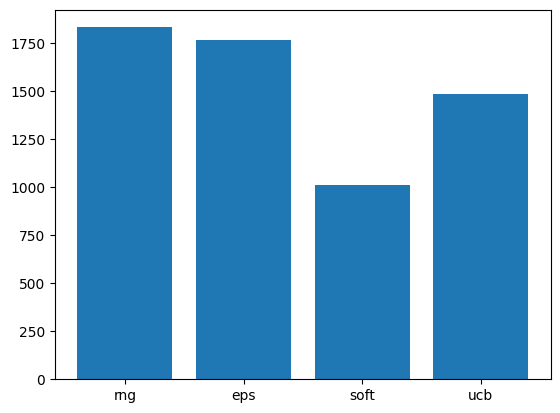

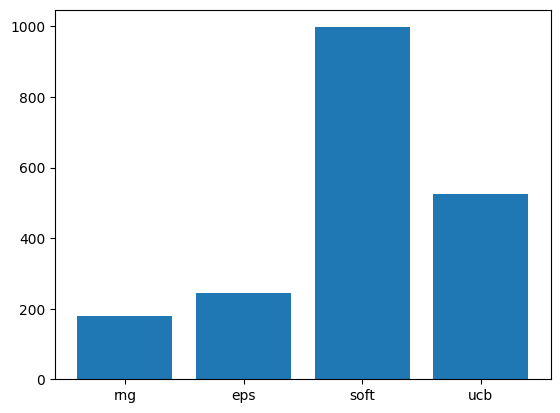

In [191]:
# Run experiment & plot
STEPS = 2000
results = experiment(k=20, steps=STEPS, runs=300)
print(results)
plt.figure()
plt.bar(["rng","eps","soft","ucb"],[results['rnd_avg_reward'][STEPS-1],results['eps_avg_reward'][STEPS-1],results['soft_avg_reward'][STEPS-1],results['ucb_avg_reward'][STEPS-1],])
plt.figure()
plt.bar(["rng","eps","soft","ucb"],[results['rnd_avg_regret'][STEPS-1],results['eps_avg_regret'][STEPS-1],results['soft_avg_regret'][STEPS-1],results['ucb_avg_regret'][STEPS-1],])
